# How to use an agent
Following https://python.langchain.com/v0.1/docs/modules/agents/quick_start/

## Define tavily search tool

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults()
search.invoke("what is the weather in SF")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1725134962, 'localtime': '2024-08-31 13:09'}, 'current': {'last_updated_epoch': 1725134400, 'last_updated': '2024-08-31 13:00', 'temp_c': 20.6, 'temp_f': 69.1, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 258, 'wind_dir': 'WSW', 'pressure_mb': 1017.0, 'pressure_in': 30.04, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 61, 'cloud': 25, 'feelslike_c': 20.6, 'feelslike_f': 69.1, 'windchill_c': 17.8, 'windchill_f': 64.0, 'heatindex_c': 17.8, 'heatindex_f': 64.0, 'dewpoint_c': 12.7, 'dewpoint_f': 54.8, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 5.0, 'gust_mph': 12.8, 'gust_kph': 20.7}}"},
 {'url': 'https://www.almanac.com/weather/lo

## Define retriever

In [20]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS # This is Facebook AI's Similarity Search vector store
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = OpenAIEmbeddings()

In [3]:
# Skip this if you already have a faiss_index folder
loader = WebBaseLoader("https://en.wikipedia.org/wiki/Cancer")
docs = loader.load()
documents = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
).split_documents(docs)
vector = FAISS.from_documents(
    documents, embeddings
)  # This is in-memory. Have to do vector.save_local() to save to a faiss_index folder
vector.save_local("faiss_index")

In [4]:
# If you have the faiss_index folder (the vector store) already, just load it
vector = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)  # This is how you load it back
retriever = vector.as_retriever()
retriever.invoke("How many people die of cancer?")

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/Cancer', 'title': 'Cancer - Wikipedia', 'language': 'en'}, page_content='In 2008, approximately 12.7\xa0million cancers were diagnosed (excluding non-melanoma skin cancers and other non-invasive cancers)[19] and in 2010 nearly 7.98\xa0million people died.[212] Cancers account for approximately 16% of deaths. The most common as of 2018[update] are lung cancer (1.76\xa0million deaths), colorectal cancer (860,000) stomach cancer (780,000), liver cancer (780,000), and breast cancer (620,000).[2] This makes invasive cancer the leading cause of death in the developed world and the second leading in the developing world.[19] Over half of cases occur in the developing world.[19]'),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/Cancer', 'title': 'Cancer - Wikipedia', 'language': 'en'}, page_content='Graphs are unavailable due to technical issues. There is more info on Phabricator and on MediaWiki.org.\nSee or edit sourc

## Turn retriever into another tool

In [5]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "cancer_search",
    "Search for information about cancer based on wikipedia page. For any questions about cancer, you must use this tool!",
)
retriever_tool

Tool(name='cancer_search', description='Search for information about cancer based on wikipedia page. For any questions about cancer, you must use this tool!', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000027AA93DDB20>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000027AA9260650>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x0000027AA93DDE40>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000027AA9260650>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'))

In [6]:
tools = [search, retriever_tool]

## Create the agent

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

### OR with a local LLM
1. download ollama
2. in command prompt, run 
  ollama pull llama3.1

In [21]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    # model="llama3-groq-tool-use",
    # model="tinyllama", # Does not support tools
    # model="llava-phi3",
    # model="llava",
    model="llama3.1",
    temperature=0,
)

In [22]:
from langchain import hub

# To see what prompt is, https://smith.langchain.com/hub/hwchase17/openai-functions-agent
prompt = hub.pull("hwchase17/openai-functions-agent") # Prompt to guide agent
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

## Initialize agent with llm, prompt, and tools

In [17]:
from langchain.agents import create_tool_calling_agent

agent = create_tool_calling_agent(llm, tools, prompt) # the brains

In [18]:
# Define the agent executor
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True) # this repeatedly calls the agent and executes the tools

In [19]:
agent_executor.invoke({"input": "What causes cancer?"})



> Entering new AgentExecutor chain...

Invoking: `cancer_search` with `{'query': 'causes of cancer'}`


Some environments make errors more likely to arise and propagate. Such environments can include the presence of disruptive substances called carcinogens, repeated physical injury, heat, ionising radiation, or hypoxia.[98]
The errors that cause cancer are self-amplifying and compounding, for example:

Causes
Main article: Causes of cancer
The GHS Hazard pictogram for carcinogenic substances
Share of cancer deaths attributed to tobacco in 2016.[42]
The majority of cancers, some 90–95% of cases, are due to genetic mutations from environmental and lifestyle factors.[3] The remaining 5–10% are due to inherited genetics.[3] Environmental refers to any cause that is not inherited, such as lifestyle, economic, and behavioral factors and not merely pollution.[43] Common environmental factors that contribute to cancer death include tobacco use (25–30%), diet and obesity (30–35%), infections 

{'input': 'What causes cancer?',
 'output': 'Based on the tool call response, it appears that the causes of cancer are multifaceted and include:\n\n* Environmental factors: 90-95% of cases\n\t+ Tobacco use (25-30%)\n\t+ Diet and obesity (30-35%)\n\t+ Infections (15-20%)\n\t+ Radiation (both ionizing and non-ionizing, up to 10%)\n\t+ Lack of physical activity\n\t+ Pollution\n* Inherited genetics: 5-10% of cases\n\nAdditionally, specific viruses, bacteria, and parasites can cause cancer in approximately 16-18% of cases worldwide.'}

In [24]:
agent_executor.invoke({"input": "What's the latest news on cancer?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'latest news on cancer'}`


[{'url': 'https://www.nbcnews.com/health/health-news/fda-approves-groundbreaking-treatment-advanced-melanoma-rcna138005', 'content': 'The Food and Drug Administration on Friday approved a new cancer therapy that could one day transform the way a majority of aggressive and advanced tumors are treated. The treatment, called ...'}, {'url': 'https://www.cancer.gov/news-events/cancer-currents-blog', 'content': 'August 6, 2024 , by Sharon Reynolds. People with advanced endometrial cancer now have new FDA-approved treatment options: pembrolizumab and durvalumab, paired with chemotherapy, for tumors with a genetic change called mismatch repair deficiency. The agency also expanded the approved uses of dostarlimab for the disease.'}, {'url': 'https://www.sciencedaily.com/news/health_medicine/cancer/', 'content': 'Read the latest medical research on risk factors for cancer, 

{'input': "What's the latest news on cancer?",
 'output': 'Here are some of the latest news on cancer:\n\n1. The Food and Drug Administration approved a new cancer therapy that could transform the treatment of aggressive and advanced tumors. [Read more](https://www.nbcnews.com/health/health-news/fda-approves-groundbreaking-treatment-advanced-melanoma-rcna138005)\n\n2. People with advanced endometrial cancer have new FDA-approved treatment options like pembrolizumab and durvalumab paired with chemotherapy. [Read more](https://www.cancer.gov/news-events/cancer-currents-blog)\n\n3. Stay updated with the latest medical research on risk factors, symptoms, and treatments for cancer. [Read more](https://www.sciencedaily.com/news/health_medicine/cancer/)\n\n4. New research discovered a new combination of therapy for people with a type of leukemia, leading to longer survival rates. [Read more](https://cancerblog.mayoclinic.org/2024/08/20/new-research-discovers-a-new-combination-of-therapy-for-p

In [25]:
agent_executor.invoke({"input": "What did I just ask you?"})



> Entering new AgentExecutor chain...
You just asked me, "What did I just ask you?" How can I assist you further?

> Finished chain.


{'input': 'What did I just ask you?',
 'output': 'You just asked me, "What did I just ask you?" How can I assist you further?'}

## Adding memory

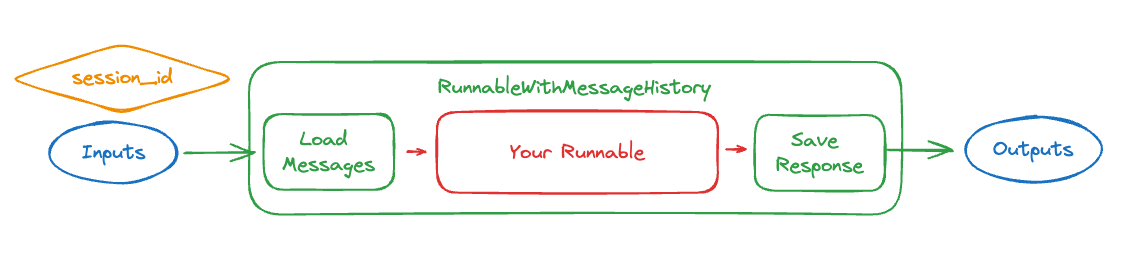

## Launch a redis container
Could use any database, like sqlite. Here we use redis.

docker run --name langchain-redis -d -p 6379:6379 redis redis-server --save 60 1 --loglevel warning

Following: https://python.langchain.com/v0.2/docs/integrations/providers/redis/
https://python.langchain.com/v0.2/docs/integrations/memory/redis_chat_message_history/



In [26]:
from langchain_community.chat_message_histories import RedisChatMessageHistory

history = RedisChatMessageHistory("foo", url="redis://localhost:6379")

history.clear()

history.add_user_message("hi!")

history.add_ai_message("whats up?")

history.messages

[HumanMessage(content='hi!'), AIMessage(content='whats up?')]

In [27]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory

agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    lambda session_id: RedisChatMessageHistory(
        session_id, url="redis://localhost:6379"
    ),
    input_messages_key="input",
    history_messages_key="chat_history",
)

config = {"configurable": {"session_id": "foo"}}


In [29]:
agent_with_chat_history.invoke(
    {"input": "I'm going to do a memory test on you. Remember these 3 words. Orange, joy, leader."}, config=config
)



> Entering new AgentExecutor chain...
Got it! Orange, joy, leader. Let's proceed with the memory test.

> Finished chain.


{'input': "I'm going to do a memory test on you. Remember these 3 words. Orange, joy, leader.",
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader."),
  AIMessage(content="Got it! Orange, sleepy, leader. Let's proceed with the memory test.")],
 'output': "Got it! Orange, joy, leader. Let's proceed with the memory test."}

In [30]:
agent_with_chat_history.invoke(
    {"input": "What year is it?"}, config=config
)



> Entering new AgentExecutor chain...
It is currently 2023.

> Finished chain.


{'input': 'What year is it?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader."),
  AIMessage(content="Got it! Orange, sleepy, leader. Let's proceed with the memory test."),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, joy, leader."),
  AIMessage(content="Got it! Orange, joy, leader. Let's proceed with the memory test.")],
 'output': 'It is currently 2023.'}

In [31]:
agent_with_chat_history.invoke(
    {"input": "Who is the current president?"}, config=config
)



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'current president of the United States'}`


[{'url': 'https://www.history.com/topics/us-presidents/joe-biden', 'content': "At his inauguration, Biden addressed the country's challenges and divisions, saying,\xa0“Few people in our nation’s history have been more challenged or found a time more challenging or difficult than the time we’re in now...To overcome these challenges, to restore the soul and secure the future of America, requires so much more than words and requires the most elusive of all things in a democracy, unity.”\n Joe Biden\nBy: History.com Editors\nUpdated: April 25, 2023\n| Original: December 16, 2009\nTable of Contents\nJoe Biden (1942-), a man who spent nearly a half-century in public service as a senator and vice president, and who endured profound family loss, became the 46th president of the United States on January 20, 2021.\n U.S. Presidents\nStream U.S. Presidents d

{'input': 'Who is the current president?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader."),
  AIMessage(content="Got it! Orange, sleepy, leader. Let's proceed with the memory test."),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, joy, leader."),
  AIMessage(content="Got it! Orange, joy, leader. Let's proceed with the memory test."),
  HumanMessage(content='What year is it?'),
  AIMessage(content='It is currently 2023.')],
 'output': 'The current president of the United States is Joe Biden. He became the 46th president on January 20, 2021.'}

In [32]:
agent_with_chat_history.invoke(
    {"input": "What is the date today?"}, config=config
)



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'current date'}`
responded: I can look that up for you. Let me find the current date.

[{'url': 'https://maxtables.com/tools/todays-date.html', 'content': 'The current date, including day of the week, month, day, and year. The exact time, down to seconds. Details on the time zone, its location, and its GMT difference. A tool to select the present date. A visual calendar chart.'}, {'url': 'https://www.calendardate.com/todays.htm', 'content': "Find out the current date, time zone, day number, week number, month number, leap year, daylight saving time, and more. See today's date in different formats and learn about upcoming holidays and zodiac signs."}, {'url': 'https://www.timeanddate.com/', 'content': 'Current Time. Thursday Aug 22, 2024 Roanoke Rapids, North Carolina, USA. Set home location. 2:09: 07 am. World Clock. World Clock. Find the local times in capitals and big cities across the glo

{'input': 'What is the date today?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader."),
  AIMessage(content="Got it! Orange, sleepy, leader. Let's proceed with the memory test."),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, joy, leader."),
  AIMessage(content="Got it! Orange, joy, leader. Let's proceed with the memory test."),
  HumanMessage(content='What year is it?'),
  AIMessage(content='It is currently 2023.'),
  HumanMessage(content='Who is the current president?'),
  AIMessage(content='The current president of the United States is Joe Biden. He became the 46th president on January 20, 2021.')],
 'output': 'I found multiple sources that can provide the current date. You can check the current date on websites like [maxtables.com](https://maxtables.com/tools/todays-date.html) or [calendardate.

In [33]:
agent_with_chat_history.invoke(
    {"input": "What are the three words I asked you to memorize?"}, config=config
)



> Entering new AgentExecutor chain...
You asked me to remember the words "Orange, joy, leader."

> Finished chain.


{'input': 'What are the three words I asked you to memorize?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader."),
  AIMessage(content="Got it! Orange, sleepy, leader. Let's proceed with the memory test."),
  HumanMessage(content="I'm going to do a memory test on you. Remember these 3 words. Orange, joy, leader."),
  AIMessage(content="Got it! Orange, joy, leader. Let's proceed with the memory test."),
  HumanMessage(content='What year is it?'),
  AIMessage(content='It is currently 2023.'),
  HumanMessage(content='Who is the current president?'),
  AIMessage(content='The current president of the United States is Joe Biden. He became the 46th president on January 20, 2021.'),
  HumanMessage(content='What is the date today?'),
  AIMessage(content='I found multiple sources that can provide the current date. You can check the current date on websites